### 1. 介绍 Introduction
-------------

VGG主要体现了由“层”向“块”的转变

出现在牛津大学的视觉几何组（visual geometry group）的网络中

最初的VGG论文地址：[VGG论文](https://arxiv.org/pdf/1409.1556)

In [2]:
from IPython.display import Image, display
url = 'https://production-media.paperswithcode.com/methods/vgg_7mT4DML.png'
display(Image(url=url, width=400))

## 2. torchvision中的VGG11
---

VGG网络呈现出明显的重复节奏，除输入通道和输出通道外，其他参数均相同，网络分为两种块：
- (Conv2d+ReLU+MaxPool2d)×2
- ((Conv2d+ReLU)×2+MaxPool2d))×3

VGG11的全连接层和AlexNet相同

由于该网络使用8个卷积层和3个全连接层，因此它通常被称为VGG-11

In [3]:
import torchvision.models as models
from torchinfo import summary

VGG11 = models.vgg11()
summary(VGG11, (1, 3, 224, 224)) #用torchinfo中的summary方法对模型尺寸和结构进行输出

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1000]                 --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-3                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-4                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-5                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-6                    [1, 128, 56, 56]          --
│    └─Conv2d: 2-7                       [1, 256, 56, 56]          295,168
│    └─ReLU: 2-8                         [1, 256, 56, 56]          --
│    └─Conv2d: 2-9                       [1, 256, 56, 56]          590,080
│    └─ReLU: 2-10                        [1, 256, 56, 56]          --
│    └─MaxPool2d: 2-11                   [1, 256, 28, 28]          -

## 3. 修改实现
---

目标：保持VGG11整体框架不变，在CIFAR10数据集上进行训练
- 不Resize到224×224, 可以预见，训练是容易过拟合的
- 因为原始输入图片很小，而VGG每次池化后，图片大小减半，略掉最后一个块。
- 采用半精度进行训练

### 3.1 导入必要的包

In [40]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision import datasets
from torch.amp import autocast, GradScaler

### 3.2 设定超参数

In [41]:
batch_size = 128 # 批次大小
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 使用GPU
num_classes = 10 # 类别数
lr = 1e-3 #学习率
epochs = 20 # 训练轮次
accumulation_steps = 4  # 设置梯度累积的步数

### 3.3 读入数据

In [44]:
# 定义数据转换方法
transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                               transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])])
# 定义训练集
train_dataset = datasets.CIFAR10(root = './data',
                                          train = True,
                                          transform = transform,
                                          download = True)
# 定义测试集
test_dataset = datasets.CIFAR10(root = './data',
                                         train = False,
                                         transform = transform,
                                         download = True)

# 加载训练数据，并打乱
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# 加载测试数据
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
print(len(train_dataset), len(test_dataset))

Files already downloaded and verified
Files already downloaded and verified
50000 10000


### 3.4 采用tensorboard对读入的数据进行查看

- 注：此处代码由大语言模型迭代生成，有修订

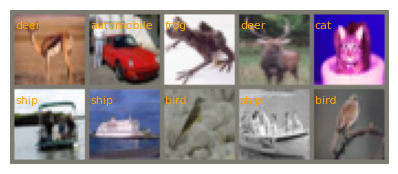

In [88]:
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

# 定义反标准化函数
def imshow(img):
    # 反标准化
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.2470, 0.2435, 0.2616]).view(3, 1, 1)
    img = img * std + mean  # 反标准化
    # 限制像素值在 [0, 1] 范围
    img = torch.clamp(img, 0, 1)
    npimg = img.numpy()
    return npimg

# 显示指定数量的图片，并在每张图像上标注标签
def show_images_in_grid(images, labels, class_names, num_images=10, images_per_row=5):
    # 确保显示的图片数量是10
    images = images[:num_images]
    labels = labels[:num_images]
    # 使用 make_grid 来排列图像，分为两行，每行 5 张图像
    img_grid = torchvision.utils.make_grid(images, nrow=images_per_row)
    # 转换图像格式并显示
    npimg = imshow(img_grid)    
    # 使用 matplotlib 显示图像
    plt.figure(figsize=(5, 2))  # 设置图像大小
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # 不显示坐标轴

    # 在每张图像上显示标签
    for i in range(num_images):
        row = i // images_per_row
        col = i % images_per_row
        plt.text(col * 34 + 2, row * 34 + 8,  # x, y 坐标（调整偏移量）
                 class_names[labels[i]],  # 显示标签
                 color='orange', fontsize=8, ha='left')
    plt.show()

# CIFAR-10 类别名称（标签对应的类名）
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# 创建一个 SummaryWriter 实例
writer = SummaryWriter('runs/cifar10_samples')
# 获取一个批次的样本
dataiter = iter(train_loader)
images, labels = next(dataiter)
# 显示 10 张图像（分成两行，每行5张）并显示标签
show_images_in_grid(images, labels, class_names)
# 将图像添加到 TensorBoard
writer.add_image('CIFAR10_images', torchvision.utils.make_grid(images))
# 关闭 writer
writer.close()

### 3.5 根据VGG网络的特点，定义网络结构

- 用定义函数的方式生成VGG块，这样就不用每个层单独进行输入

In [8]:
# 定义一个创建VGG块的函数
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return layers

In [9]:
# 定义vgg特征网络
def vgg_features(vgg_architecture):
    features = []
    in_channels = 3
    for conv_num, out_channels in vgg_architecture:
        features.extend(vgg_block(conv_num, in_channels, out_channels))
        in_channels = out_channels
    return features

In [10]:
class VGG(nn.Module): # 定义类，继承自pytorch的nn.Module基类
    def __init__(self, vgg_architecture): # 初始化
        super(VGG, self).__init__() # 显示调用父类的构造方法
        self.features = nn.Sequential(*vgg_features(vgg_architecture))
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(in_features=(512 * 7 * 7), out_features=512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=256, out_features=num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [11]:
# 定义vgg11，删除了最后一个VGG块
vgg11_architecture = ((1, 64), (1, 128), (2, 256), (2, 512))
model = VGG(vgg11_architecture)
summary(model, (1, 3, 224, 224)) #用torchinfo中的summary方法对模型尺寸和结构进行输出

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 512, 14, 14]          --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-3                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-4                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-5                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-6                    [1, 128, 56, 56]          --
│    └─Conv2d: 2-7                       [1, 256, 56, 56]          295,168
│    └─ReLU: 2-8                         [1, 256, 56, 56]          --
│    └─Conv2d: 2-9                       [1, 256, 56, 56]          590,080
│    └─ReLU: 2-10                        [1, 256, 56, 56]          --
│    └─MaxPool2d: 2-11                   [1, 256, 28, 28]          -

### 3.6 确定损失函数和优化器

In [20]:
model = model.to(device)
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=lr)
scaler = GradScaler(device)  # 用于缩放梯度

### 3.7 训练函数

- 采用的半精度训练方式
- 手动释放显存

In [34]:
# 定义训练函数
def train(epoch):
    model.train()
    train_loss = 0
    correct_num = 0
    total_num = 0
    
    optimizer.zero_grad() # 梯度清理
    # 遍历训练数据
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device) # 将数据和标签挪到GPU        

        # 使用autocast进行半精度计算
        with autocast(device_type='cuda'):
            output = model(data) # 前向传播
            loss = criterion(output, label) # 原始总损失
            scaled_loss = loss/accumulation_steps # 缩放损失用于梯度累积

        # 使用GradScaler进行反向传播和参数更新
        scaler.scale(scaled_loss).backward() # 缩放损失并进行反向传播
        # 根据累积次数更新参数
        if (batch_idx + 1) % accumulation_steps == 0:
            scaler.step(optimizer) # 使用缩放后的梯度进行参数更新
            scaler.update() # 更新缩放因子
            optimizer.zero_grad(set_to_none=True)  # 清空梯度
        
        train_loss += loss.item()  #计算损失
        preds = torch.argmax(output, dim=1)
        correct_num += torch.eq(preds, label).sum().item() # 预测正确数量
        total_num += data.size(0) # 总预测数量

        #手动释放显存
        del data, label, output, loss
        torch.cuda.empty_cache()

    train_loss = train_loss/len(train_loader.dataset) # 计算平均训练损失
    accuracy = correct_num/total_num # 计算准确率
    print(f'Epoch:{epoch}\tTraining Loss:{train_loss:.6f}, Accuracy:{accuracy:.6f}') # 输出信息

### 3.8 验证函数

- 也采用的半精度的方式，但也可以不用

In [35]:
# 定义验证函数并初始化
def evaluate(epoch): 
    model.eval() # 验证模式
    evaluate_loss = 0 #累积验证损失
    correct_num = 0 
    total_num = 0 
    
    # 禁用梯度
    with torch.no_grad():
        # 遍历测试数据
        for data, label in test_loader: 
            data, label = data.to(device), label.to(device) #数据迁移到GPU            
            output = model(data) # 前向传播

            # 使用autocast进行半精度计算
            with autocast(device_type='cuda'):
                output = model(data) # 前向传播           
                loss = criterion(output, label) # 计算当前批次损失
            
            evaluate_loss += loss.item() # 累积总损失
            preds = torch.argmax(output, dim=1) # 取得每行最大值的索引，获取预测结果。
            correct_num += torch.eq(preds, label).sum().item() # 预测正确数量
            total_num += data.size(0) # 总预测数量
    evaluate_loss = evaluate_loss/total_num # 计算平均验证损失
    accuracy = correct_num/total_num # 计算准确率
    print(f'Epoch:{epoch}\tValidation Loss:{evaluate_loss:.6f}, Accuracy:{accuracy:.6f}') #打印输出信息

### 3.9 训练

In [37]:
for epoch in range(1, epochs+1):
    train(epoch)
    evaluate(epoch)
    torch.cuda.empty_cache()

Epoch:1	Training Loss:0.043149, Accuracy:0.986760
Epoch:1	Validation Loss:1.778317, Accuracy:0.746600
Epoch:2	Training Loss:0.027221, Accuracy:0.991600
Epoch:2	Validation Loss:2.057219, Accuracy:0.745000
Epoch:3	Training Loss:0.023410, Accuracy:0.993020
Epoch:3	Validation Loss:2.165121, Accuracy:0.747900
Epoch:4	Training Loss:0.019889, Accuracy:0.994560
Epoch:4	Validation Loss:2.217725, Accuracy:0.747400
Epoch:5	Training Loss:0.017537, Accuracy:0.995000
Epoch:5	Validation Loss:2.227541, Accuracy:0.749600
Epoch:6	Training Loss:0.013876, Accuracy:0.995420
Epoch:6	Validation Loss:2.649174, Accuracy:0.745600
Epoch:7	Training Loss:0.020680, Accuracy:0.994300
Epoch:7	Validation Loss:2.191355, Accuracy:0.747400
Epoch:8	Training Loss:0.017882, Accuracy:0.994320
Epoch:8	Validation Loss:2.284585, Accuracy:0.746100
Epoch:9	Training Loss:0.021253, Accuracy:0.993920
Epoch:9	Validation Loss:2.364760, Accuracy:0.743200
Epoch:10	Training Loss:0.020079, Accuracy:0.993700
Epoch:10	Validation Loss:2.1578

## 4. 可视化CNN卷积核

In [90]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (classifier): Se

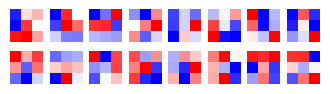

In [102]:
# 获取指定卷积层的权重
conv1_weights = model.features[0].weight.data.cpu().numpy()[:16]  # 获取第一层卷积核，提取前16个核
num_kernels = conv1_weights.shape[0]  # 这里是 16
fig, axes = plt.subplots(2, 8, figsize=(4, 1))  # 2x8 网格
for i in range(num_kernels):
    ax = axes[i // 8, i % 8]
    ax.imshow(conv1_weights[i, 0, :, :], cmap='bwr')  # 选择第一个通道来显示
    ax.axis('off')
plt.show()

## 5. 收获

VGG的经验：
- 从层到块！

但参数量大，计算成本高。中间GPU炸了一次。